In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as am
import vartests

0.1.9


In [2]:
columns = ['SPX', 'DAX', 'WIG20', 'EURUSD']
data = pd.read_csv('study_data.csv', header=0, names=['Date', 'SPX', 'DAX', 'WIG20', 'EURUSD'], index_col='Date', parse_dates=['Date'])

In [3]:
#predict implied volatility and VaR based on multivariate GARCH(1,1) model
b_var_forecast = pd.read_csv('varf_h_forecast_bayesian.csv', parse_dates=['Date'], index_col='Date')
b_var_forecast

,SPX,DAX,WIG20,EURUSD
Date,,,,
2013-02-11,0.411755,1.275139,1.171095,0.163066
2013-02-12,0.480419,0.564075,-0.315363,0.130588
2013-02-13,-2.197032,-3.328634,-2.204327,-1.189345
2013-02-14,-0.098943,-0.322014,-1.134790,-0.265777
2013-02-15,-1.042522,-1.553301,-0.570440,-0.511490
...,...,...,...,...
2022-03-14,-2.514751,-2.662885,-3.138229,-0.137563
2022-03-15,-1.608996,-0.768789,-0.709772,-0.117092
2022-03-16,-0.580955,0.042155,-1.432334,0.023891


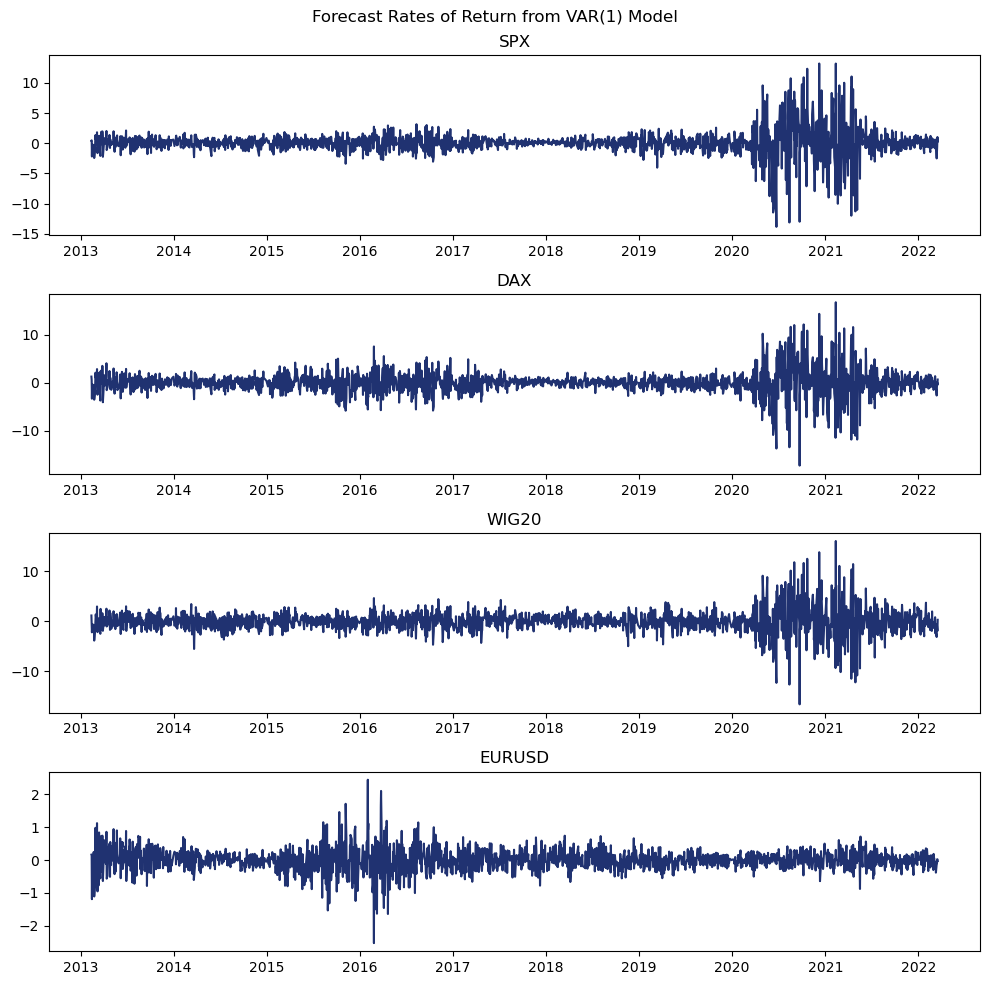

In [4]:
#plot forecast rates of return
fig, ax = plt.subplots(4, 1, dpi=100, figsize=(10,10))
plt.suptitle('Forecast Rates of Return from VAR(1) Model')

a=0
for i in columns:
    ax[a].plot(b_var_forecast[i], c='#203271')
    ax[a].set_title('%s' %i)
    a += 1
    
plt.tight_layout()
plt.show()
fig.savefig('returns forecast bayesian.png', bbox_inches='tight')

In [5]:
#porfolio weights vector omega_t (time-constant)
omega = np.array([.625, .235, .11, .03])

In [6]:
#H-matrices forecast
H_b_forecast = pd.read_csv('dccf_H_forecast_bayesian.csv')
H_b_forecast

,H11,H12,H13,H14,H21,H22,H23,H24,H31,H32,H33,H34,H41,H42,H43,H44
0,0.610120,0.688360,0.452032,0.227313,0.688360,1.459459,0.939307,0.331352,0.452032,0.939307,1.387960,0.244768,0.227313,0.331352,0.244768,0.349152
1,0.664117,0.683270,0.473868,0.249968,0.683270,1.394008,0.908004,0.323494,0.473868,0.908004,1.276445,0.253931,0.249968,0.323494,0.253931,0.364554
2,1.007064,0.752703,0.665991,0.281925,0.752703,1.326328,0.845417,0.275688,0.665991,0.845417,1.377176,0.258116,0.281925,0.275688,0.258116,0.325468
3,0.749560,0.603049,0.498753,0.242718,0.603049,1.184219,0.761466,0.245529,0.498753,0.761466,1.288123,0.238225,0.242718,0.245529,0.238225,0.335034
4,1.079430,0.903475,0.553659,0.247488,0.903475,1.598430,0.796724,0.213590,0.553659,0.796724,1.182114,0.219017,0.247488,0.213590,0.219017,0.346685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.727402,0.430931,0.420326,0.112934,0.430931,0.979680,0.863133,0.072835,0.420326,0.863133,2.499666,0.106235,0.112934,0.072835,0.106235,0.155034
99,0.755806,0.342553,0.531963,0.169436,0.342553,0.705663,0.627687,0.030640,0.531963,0.627687,1.942645,0.148965,0.169436,0.030640,0.148965,0.220557
100,0.929990,0.440993,0.349625,0.110404,0.440993,0.894748,0.552033,0.021502,0.349625,0.552033,1.325877,0.043366,0.110404,0.021502,0.043366,0.148962
101,2.488260,0.845702,0.636420,0.072860,0.845702,1.167391,0.678141,-0.022028,0.636420,0.678141,1.402686,0.023463,0.072860,-0.022028,0.023463,0.161212


In [7]:
#VaR forecast
from scipy.stats import norm

z_alpha = norm().ppf(.95)
VaR = []
j = 0

for i in range(len(b_var_forecast)):
    if (((i%20)==0) & (i!=20)):
        j+=1
    H_b_t = np.array(H_b_forecast.iloc[j]).reshape((4,4)).T
    VaR_b = (1-np.exp(omega@b_var_forecast.iloc[i]+z_alpha*np.sqrt(omega.T@H_b_t@omega)))
    VaR.append(VaR_b)

VaR = pd.DataFrame(VaR, columns=['VaR forecast'], index=b_var_forecast.index)
VaR

,VaR forecast
Date,
2013-02-11,-6.750030
2013-02-12,-4.806783
2013-02-13,0.659231
2013-02-14,-1.964376
2013-02-15,-0.299896
...,...
2022-03-14,0.576658
2022-03-15,-0.521016
2022-03-16,-2.245350


In [8]:
#VaR assessment
#calculate portfolio returns
data_short = data.iloc[-len(b_var_forecast):]
daily_return = []

for i in range(len(b_var_forecast)):
    portfolio_daily_return = data_short[columns].iloc[i]@omega.T
    daily_return.append(portfolio_daily_return)

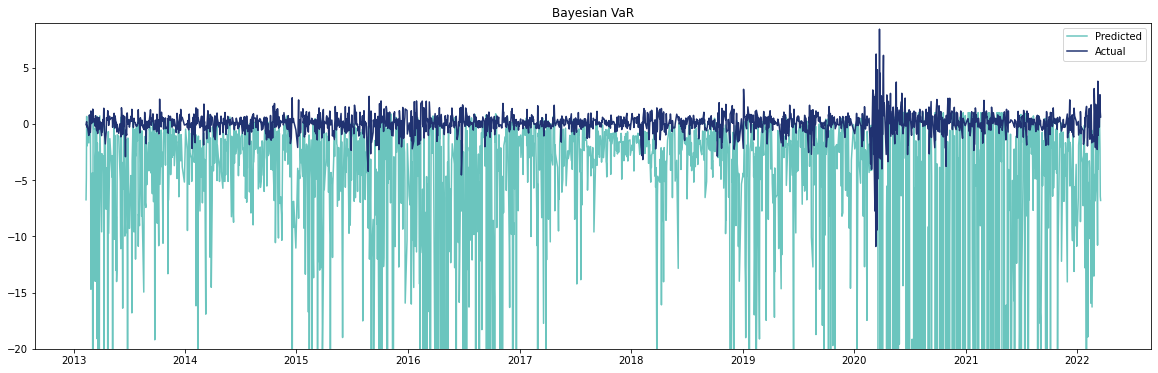

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure(figsize=(20,6))
plt.plot(VaR, color='#6bc5be')
plt.plot(data_short.index, daily_return, c='#203271')
plt.ylim((-20, 9))
plt.title('Bayesian VaR')
plt.legend(['Predicted','Actual'])
plt.show()
plt.savefig('bayesian VaR.png', bbox_inches='tight')

In [10]:
VaR['Actual'] = daily_return
VaR['Exceeded'] = np.where(VaR['VaR forecast']>VaR['Actual'], True, False)
VaR

,VaR forecast,Actual,Exceeded
Date,,,
2013-02-11,-6.750030,-0.075559,False
2013-02-12,-4.806783,0.070751,False
2013-02-13,0.659231,0.197663,True
2013-02-14,-1.964376,-0.290953,False
2013-02-15,-0.299896,-0.131097,False
...,...,...,...
2022-03-14,0.576658,-0.282426,True
2022-03-15,-0.521016,1.466094,False
2022-03-16,-2.245350,2.591730,False


In [11]:
print('VaR exceeded %10.4f' % float(sum(VaR['Exceeded'])*100/len(VaR)), '% of the time')

VaR exceeded    12.5243 % of the time


In [12]:
vartests.kupiec_test(VaR['Exceeded'], var_conf_level=0.95, conf_level=0.95)

OverflowError: integer division result too large for a float